In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, accuracy_score, recall_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE, ADASYN
import category_encoders as ce
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

import sys
import os
import pickle
import time

# Add the path to the project root directory to the python path
sys.path.append(os.path.abspath("C:/Users/mabid/OneDrive/Desktop/Projects - Ongoing/BNP Credit Card Fraud Detection/fraud_detection/"))

from src.features import build_features

# 0 - Defining custom functions and pipelines for preprocessing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, accuracy_score, recall_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE, ADASYN
import category_encoders as ce
import xgboost as xgb
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


class ColumnManipulatorDrop(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.category_df = ['item', 'cash_price', 'make']
        self.category_todelete = ['model', 'goods_code', 'Nbr_of_prod_purchas']
        self.delete_columns = []

    def generate_delete_columns(self):
        for i in self.category_df:
            for j in range(4, 25):
                self.delete_columns.append(i + str(j))
        for i in self.category_todelete:
            for j in range(1, 25):
                self.delete_columns.append(i + str(j))
        # Uncomment the line below if you want to include 'ID' in delete_columns
        # self.delete_columns.append('ID')
        return self.delete_columns
    
    def fit(self, df, y=None):
        return self
    
    def transform(self, df):
        delete_columns = self.generate_delete_columns()
        df_drop = df.drop(columns=delete_columns)
        return df_drop

class featureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, df, y=None):
        return self
    
    def transform(self, df):
        df["Total_price"] = df.loc[:, [col for col in df.columns if "cash_price" in col]].sum(axis=1)
        df["Total_items"] = df.loc[:, [f"Nbr_of_prod_purchas{i}" for i in range(1, 25)]].sum(axis=1)
        df["Price_per_total_purchases"] = df["Total_price"] / df["Total_items"]
        df["Price_per_unique_item"] = df["Total_price"] / df["Nb_of_items"]
        return df

class CleanItems(BaseEstimator, TransformerMixin):
    def fit(self, df, y=None):
        return self
    
    def transform(self, df):
        item = ['item1', 'item2', 'item3']
        for i in item:
            df[i] = df[i].str.replace("\s&", "", regex=True).str.replace(",", "", regex=True)
        return df

    
class preprocess(BaseEstimator, TransformerMixin):
    def fit(self, df, y=None):
        self.numerical_col = [col for col in df.columns
                 if df[col].dtypes in ['float64']]
        self.categorical_col = [col for col in df.columns
                   if df[col].dtypes in ['object']]
        self.onehot = OneHotEncoder()
        return self
    
    def transform(self, df):
        df_num = df[self.numerical_col]
        df_cat = df[self.categorical_col]

        #impute NaN 
        df_num = df_num.fillna(0)
        df_cat = df_cat.fillna('None')

        #Keep the categories that are more related to fraud cases
        make = ['make1', 'make2', 'make3']
        categoryToKeep = ['APPLE', 'SONY', 'LG', 'SAMSUNG', 'None']
        for i in make:
            for j in df_cat.index:
                if df_cat[i][j] not in categoryToKeep:
                    df_cat[i][j] = 'OTHER'
        
        #Keep the items that are more related to fraud cases
        item = ['item1', 'item2', 'item3']
        itemsToKeep = ['COMPUTERS', 'COMPUTER PERIPHERALS ACCESSORIES', 'TELEPHONES FAX MACHINES TWO-WAY RADIOS', 'TELEVISIONS HOME CINEMA']
        for i in item:
            for j in df_cat.index:
                if df_cat[i][j] not in itemsToKeep:
                    df_cat[i][j] = 'OTHER'

        #One Hot Encoding the categorical features
        if not self.fit:
            cat_oh = self.onehot.transform(df_cat)
        else:
            cat_oh = self.onehot.fit_transform(df_cat)
        df_cat_oh = pd.DataFrame(cat_oh.toarray(), columns=self.onehot.get_feature_names_out(self.categorical_col), index=df.index)

        #Concatenate df_num and df_cat
        df_prep = pd.concat([df_num, df_cat_oh], axis=1)

        return df_prep

# 1 - Defining the pipeling and modeling

Investigate the fraud flag position within the pipeline

In [15]:
TRAIN_DATA = "../data/processed/model_train_data.csv"
PARAMS_FILE = "../models/01-Anas-XGBTuned-14_02_2024.pickle"
OUTPUT_FILE_NAME = f"../models/01-Anas-XGBTuned-{time.strftime('%d_%b_%Y_%H_%M_%S')}.pickle"
RANDOM_STATE = 42

# Block 1 : Preprocessing Pipline
feng = build_features.featureEngineering()
cd = build_features.ColumnManipulatorDrop()
ci = build_features.CleanItems()
pp = build_features.preprocess()

pipe = Pipeline([
    ('featEngineering', feng),
    ('dropColumns', cd),
    ('cleaning', ci),
    ('preprocessing', pp)
])

# Block 2 : Model Training

# Read the data
df_train = pd.read_csv(TRAIN_DATA, index_col=0)
y = df_train.pop("fraud_flag")

# Load the model parameters
params = pickle.load(open(PARAMS_FILE, "rb"))

# Split the data & train the model (xgbDMatrix usde)
X_train, X_test, y_train, y_test = train_test_split(df_train, y, train_size=0.8, random_state=RANDOM_STATE)

X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

dtrain = xgb.DMatrix(X_train, y_train.values)
dtest = xgb.DMatrix(X_test, y_test.values)
watchlist = [(dtrain, 'train'), (dtest, 'valid')]

model = xgb.train(params, 
                dtrain, 
                1000, 
                watchlist, 
                early_stopping_rounds=100, 
                maximize=True, 
                verbose_eval=50)


# Block 3 : Inference Pipeline
y_pred_train = model.predict(dtrain)
y_pred_test = model.predict(dtest)

y_true_train = y_train.values
y_true_test = y_test.values

print(f"len(y_true_train): {len(y_true_train)}, len(y_pred_train): {len(y_pred_train)}, {'Matching lengths' if len(y_true_train) == len(y_pred_train) else 'None Matching lengths'}")
print(f"len(y_true_test): {len(y_true_test)}, len(y_pred_test): {len(y_pred_test)}, {'Matching lengths' if len(y_true_train) == len(y_pred_train) else 'None Matching lengths'}")

# Save the model
output = {"model": model,
          "model_params_explicit": params if PARAMS_FILE else None,
          "pipe": pipe,
          "model_name": "XGBoost",
          "prediction_matrix_type": "xgb.DMatrix",
          "y_true_train": y_true_train,
          "y_pred_train": y_pred_train,
          "y_true_test": y_true_test,
          "y_pred_test": y_pred_test,}

pickle.dump(output, open(OUTPUT_FILE_NAME, "wb"))

C:\Users\mabid\AppData\Local\Temp\ipykernel_5288\2196362945.py:22: DtypeWarning: Columns (23,24,71,72,95,96,97,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(TRAIN_DATA, index_col=0)


[0]	train-auc:0.79411	valid-auc:0.77408


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [07:14:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.87022	valid-auc:0.82930
[100]	train-auc:0.88023	valid-auc:0.83393
[150]	train-auc:0.88556	valid-auc:0.83682
[200]	train-auc:0.89035	valid-auc:0.83732
[250]	train-auc:0.89538	valid-auc:0.83932
[300]	train-auc:0.89928	valid-auc:0.83982
[350]	train-auc:0.90335	valid-auc:0.84184
[400]	train-auc:0.90595	valid-auc:0.84248
[450]	train-auc:0.90922	valid-auc:0.84221
[500]	train-auc:0.91214	valid-auc:0.84232
[550]	train-auc:0.91442	valid-auc:0.84272
[600]	train-auc:0.91643	valid-auc:0.84187
[640]	train-auc:0.91800	valid-auc:0.84227
len(y_true_train): 59385, len(y_pred_train): 59385, Matching lengths
len(y_true_test): 14847, len(y_pred_test): 14847, Matching lengths


In [6]:
y_pred_train = model.predict(dtrain)
y_pred_valid = model.predict(dvalid)

y_true_train = y_train.values
y_true_valid = y_valid.values

In [9]:
len(y_true_train), len(y_pred_train), len(y_true_valid), len(y_pred_valid)

(59385, 59385, 14847, 14847)

In [5]:
model.predict(dtrain)

array([0.02851374, 0.00171542, 0.011183  , ..., 0.01844703, 0.02475948,
       0.0019173 ], dtype=float32)

In [15]:
with pd.option_context('display.max_columns', None):
    display(X_train)

cols = list(X_train.columns)
cols.sort()

,cash_price1,cash_price2,cash_price3,Nb_of_items,Total_price,Total_items,Price_per_total_purchases,Price_per_unique_item,item1_COMPUTER PERIPHERALS ACCESSORIES,item1_COMPUTERS,item1_OTHER,item1_TELEPHONES FAX MACHINES TWO-WAY RADIOS,item1_TELEVISIONS HOME CINEMA,item2_COMPUTER PERIPHERALS ACCESSORIES,item2_COMPUTERS,item2_OTHER,item2_TELEPHONES FAX MACHINES TWO-WAY RADIOS,item2_TELEVISIONS HOME CINEMA,item3_COMPUTER PERIPHERALS ACCESSORIES,item3_COMPUTERS,item3_OTHER,item3_TELEPHONES FAX MACHINES TWO-WAY RADIOS,item3_TELEVISIONS HOME CINEMA,make1_APPLE,make1_LG,make1_None,make1_OTHER,make1_SAMSUNG,make1_SONY,make2_APPLE,make2_LG,make2_None,make2_OTHER,make2_SAMSUNG,make2_SONY,make3_APPLE,make3_LG,make3_None,make3_OTHER,make3_SAMSUNG,make3_SONY
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
58120,1554.0,0.0,0.0,1.0,1554.0,6.0,259.0,1554.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
42075,893.0,0.0,0.0,1.0,893.0,1.0,893.0,893.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
107978,1769.0,4.0,0.0,2.0,1773.0,2.0,886.5,886.5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
108691,1749.0,1649.0,0.0,2.0,3398.0,2.0,1699.0,1699.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
37085,949.0,0.0,0.0,1.0,949.0,1.0,949.0,949.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108027,369.0,7.0,0.0,2.0,376.0,2.0,188.0,188.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
21075,929.0,0.0,0.0,1.0,929.0,1.0,929.0,929.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9778,999.0,0.0,0.0,2.0,999.0,2.0,499.5,499.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [16]:
cols

['Nb_of_items',
 'Price_per_total_purchases',
 'Price_per_unique_item',
 'Total_items',
 'Total_price',
 'cash_price1',
 'cash_price2',
 'cash_price3',
 'item1_COMPUTER PERIPHERALS ACCESSORIES',
 'item1_COMPUTERS',
 'item1_OTHER',
 'item1_TELEPHONES FAX MACHINES TWO-WAY RADIOS',
 'item1_TELEVISIONS HOME CINEMA',
 'item2_COMPUTER PERIPHERALS ACCESSORIES',
 'item2_COMPUTERS',
 'item2_OTHER',
 'item2_TELEPHONES FAX MACHINES TWO-WAY RADIOS',
 'item2_TELEVISIONS HOME CINEMA',
 'item3_COMPUTER PERIPHERALS ACCESSORIES',
 'item3_COMPUTERS',
 'item3_OTHER',
 'item3_TELEPHONES FAX MACHINES TWO-WAY RADIOS',
 'item3_TELEVISIONS HOME CINEMA',
 'make1_APPLE',
 'make1_LG',
 'make1_None',
 'make1_OTHER',
 'make1_SAMSUNG',
 'make1_SONY',
 'make2_APPLE',
 'make2_LG',
 'make2_None',
 'make2_OTHER',
 'make2_SAMSUNG',
 'make2_SONY',
 'make3_APPLE',
 'make3_LG',
 'make3_None',
 'make3_OTHER',
 'make3_SAMSUNG',
 'make3_SONY']

- Naive model parameters have been set as a beggining

In [17]:
dtrain = xgb.DMatrix(X_train, y_train.values)
dvalid = xgb.DMatrix(X_valid, y_valid.values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = 2018

model = xgb.train(params, 
                dtrain, 
                1000, 
                watchlist, 
                early_stopping_rounds=100, 
                maximize=True, 
                verbose_eval=50)

[0]	train-auc:0.69109	valid-auc:0.71008


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [07:26:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.76777	valid-auc:0.79105
[100]	train-auc:0.78543	valid-auc:0.80786
[150]	train-auc:0.80251	valid-auc:0.82187
[200]	train-auc:0.81605	valid-auc:0.83224
[250]	train-auc:0.82444	valid-auc:0.83788
[300]	train-auc:0.83165	valid-auc:0.84327
[350]	train-auc:0.83658	valid-auc:0.84621
[400]	train-auc:0.84103	valid-auc:0.84902
[450]	train-auc:0.84431	valid-auc:0.84949
[500]	train-auc:0.84636	valid-auc:0.85041
[550]	train-auc:0.84984	valid-auc:0.85286
[600]	train-auc:0.85192	valid-auc:0.85411
[650]	train-auc:0.85496	valid-auc:0.85479
[700]	train-auc:0.85691	valid-auc:0.85658
[750]	train-auc:0.85874	valid-auc:0.85694
[800]	train-auc:0.86074	valid-auc:0.85713
[850]	train-auc:0.86192	valid-auc:0.85748
[900]	train-auc:0.86316	valid-auc:0.85771
[950]	train-auc:0.86463	valid-auc:0.85768
[999]	train-auc:0.86579	valid-auc:0.85747


# 2 - Fine tuning the model

In [ ]:
#Credits to ChromaticIsobar for skopt bug fix https://github.com/scikit-optimize/scikit-optimize/issues/1138
np.int = int

from skopt import space, gp_minimize
from functools import partial

def optimize(params, param_names, dtrain, dvalid):

    params = dict(zip(param_names, params))
    params['objective'] = 'binary:logistic'
    params['silent'] = True
    params['eval_metric'] = 'auc'
    print(params)

    model = xgb.train(params, 
                dtrain, 
                1000, 
                watchlist, 
                early_stopping_rounds=100, 
                maximize=True, 
                verbose_eval=50)
    
    best_score = model.best_score
    
    return -best_score

param_space = [
    space.Real(0.01, 1, prior="uniform", name='eta'),
    space.Integer(2, 20, name='max_depth'),
    space.Real(0.01, 1, prior="uniform", name='subsample'),
    space.Real(0.01, 1, prior="uniform", name='colsample_bytree'),
    space.Integer(1, 4, name='min_samples_leaf'),
    space.Integer(2, 10, name='min_samples_split')
]

dtrain = xgb.DMatrix(X_train, y_train.values)
dvalid = xgb.DMatrix(X_valid, y_valid.values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

param_name = [item.name for item in param_space]

optimization_function = partial(optimize, param_names=param_name, dtrain = dtrain, dvalid = dvalid)

result = gp_minimize(
    optimization_function,
    dimensions=param_space,
    n_calls=50,
    n_random_starts=2,
    verbose=10
)

print(dict(zip(param_name, result.x)))

Iteration No: 1 started. Evaluating function at random point.
{'eta': 0.1021459108328417, 'max_depth': 16, 'subsample': 0.9983655436372751, 'colsample_bytree': 0.5521800046551429, 'min_samples_leaf': 1, 'min_samples_split': 5, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.82468	valid-auc:0.79953


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:48:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.91759	valid-auc:0.84777
[100]	train-auc:0.92576	valid-auc:0.84358
[125]	train-auc:0.92671	valid-auc:0.84169
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.8488
Function value obtained: -0.8518
Current minimum: -0.8518
Iteration No: 2 started. Evaluating function at random point.
{'eta': 0.6500810097570219, 'max_depth': 11, 'subsample': 0.7588108969074097, 'colsample_bytree': 0.2525217438859624, 'min_samples_leaf': 3, 'min_samples_split': 7, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.75113	valid-auc:0.75332


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:48:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.92264	valid-auc:0.83675
[100]	train-auc:0.92935	valid-auc:0.82266
[112]	train-auc:0.92965	valid-auc:0.82105
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.6648
Function value obtained: -0.8444
Current minimum: -0.8518
Iteration No: 3 started. Searching for the next optimal point.
{'eta': 0.3396460999738096, 'max_depth': 16, 'subsample': 0.9964316658434391, 'colsample_bytree': 0.2549609123458277, 'min_samples_leaf': 1, 'min_samples_split': 5, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.77065	valid-auc:0.76623


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:48:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.92320	valid-auc:0.84009
[100]	train-auc:0.92872	valid-auc:0.83463
[119]	train-auc:0.92977	valid-auc:0.83288
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 1.8159
Function value obtained: -0.8494
Current minimum: -0.8518
Iteration No: 4 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 17, 'subsample': 1.0, 'colsample_bytree': 0.8867022302723973, 'min_samples_leaf': 2, 'min_samples_split': 5, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.84155	valid-auc:0.81740


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:48:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.86846	valid-auc:0.83835
[100]	train-auc:0.87662	valid-auc:0.84197
[150]	train-auc:0.88360	valid-auc:0.84587
[200]	train-auc:0.89220	valid-auc:0.85008
[250]	train-auc:0.89981	valid-auc:0.84983
[300]	train-auc:0.90502	valid-auc:0.84811
[309]	train-auc:0.90564	valid-auc:0.84763
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 4.4841
Function value obtained: -0.8510
Current minimum: -0.8518
Iteration No: 5 started. Searching for the next optimal point.
{'eta': 0.9997894995950513, 'max_depth': 16, 'subsample': 0.38602574169994547, 'colsample_bytree': 0.7444473535732364, 'min_samples_leaf': 4, 'min_samples_split': 5, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.73983	valid-auc:0.75040


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:48:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.91512	valid-auc:0.79991
[100]	train-auc:0.92169	valid-auc:0.77451
[104]	train-auc:0.92197	valid-auc:0.78095
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 1.6832
Function value obtained: -0.8248
Current minimum: -0.8518
Iteration No: 6 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 8, 'subsample': 0.01, 'colsample_bytree': 0.31116668203805325, 'min_samples_leaf': 1, 'min_samples_split': 8, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.66304	valid-auc:0.66694


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:48:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.73872	valid-auc:0.74688
[100]	train-auc:0.74025	valid-auc:0.76872
[150]	train-auc:0.74519	valid-auc:0.76667
[200]	train-auc:0.76314	valid-auc:0.78287
[250]	train-auc:0.77148	valid-auc:0.78686
[300]	train-auc:0.77726	valid-auc:0.79258
[350]	train-auc:0.77578	valid-auc:0.78977
[400]	train-auc:0.77279	valid-auc:0.78868
[419]	train-auc:0.77440	valid-auc:0.79155
Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 4.7023
Function value obtained: -0.7943
Current minimum: -0.8518
Iteration No: 7 started. Searching for the next optimal point.
{'eta': 1.0, 'max_depth': 2, 'subsample': 1.0, 'colsample_bytree': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.69834	valid-auc:0.67981


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:48:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.70880	valid-auc:0.70990
[100]	train-auc:0.62598	valid-auc:0.62734
[106]	train-auc:0.60654	valid-auc:0.60372
Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 1.2328
Function value obtained: -0.8160
Current minimum: -0.8518
Iteration No: 8 started. Searching for the next optimal point.
{'eta': 0.35560964729658046, 'max_depth': 6, 'subsample': 0.45661336301454963, 'colsample_bytree': 0.7572747209237448, 'min_samples_leaf': 1, 'min_samples_split': 7, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.76053	valid-auc:0.76518


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:48:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.90036	valid-auc:0.84842
[100]	train-auc:0.91430	valid-auc:0.84157
[144]	train-auc:0.91944	valid-auc:0.83721
Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 2.0506
Function value obtained: -0.8517
Current minimum: -0.8518
Iteration No: 9 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 5, 'subsample': 0.01, 'colsample_bytree': 0.4967934724403644, 'min_samples_leaf': 3, 'min_samples_split': 7, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.66450	valid-auc:0.66569


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:48:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.72375	valid-auc:0.74804
[100]	train-auc:0.72806	valid-auc:0.75672
[150]	train-auc:0.73649	valid-auc:0.75677
[171]	train-auc:0.73700	valid-auc:0.76105
Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 2.1552
Function value obtained: -0.7675
Current minimum: -0.8518
Iteration No: 10 started. Searching for the next optimal point.
{'eta': 0.18036996821158588, 'max_depth': 18, 'subsample': 0.555466302511198, 'colsample_bytree': 0.7449353519118495, 'min_samples_leaf': 3, 'min_samples_split': 8, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.80969	valid-auc:0.78202


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:48:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.91980	valid-auc:0.84266
[100]	train-auc:0.92884	valid-auc:0.83294
[126]	train-auc:0.93017	valid-auc:0.83053
Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 2.6272
Function value obtained: -0.8513
Current minimum: -0.8518
Iteration No: 11 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 7, 'subsample': 1.0, 'colsample_bytree': 0.8493775498702368, 'min_samples_leaf': 1, 'min_samples_split': 3, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.80596	valid-auc:0.80458


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:48:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.84505	valid-auc:0.82221
[100]	train-auc:0.85379	valid-auc:0.82863
[150]	train-auc:0.85913	valid-auc:0.83481
[200]	train-auc:0.86338	valid-auc:0.84010
[250]	train-auc:0.87067	valid-auc:0.84214
[300]	train-auc:0.87633	valid-auc:0.84409
[350]	train-auc:0.88029	valid-auc:0.84411
[400]	train-auc:0.88414	valid-auc:0.84489
[450]	train-auc:0.88780	valid-auc:0.84744
[500]	train-auc:0.89061	valid-auc:0.84917
[550]	train-auc:0.89337	valid-auc:0.84989
[600]	train-auc:0.89563	valid-auc:0.85073
[650]	train-auc:0.89699	valid-auc:0.85093
[700]	train-auc:0.89837	valid-auc:0.85163
[750]	train-auc:0.89968	valid-auc:0.85196
[800]	train-auc:0.90125	valid-auc:0.85191
[850]	train-auc:0.90233	valid-auc:0.85158
[886]	train-auc:0.90293	valid-auc:0.85173
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 11.5410
Function value obtained: -0.8520
Current minimum: -0.8520
Iteration No: 12 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 20, 'sub

c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:48:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.79570	valid-auc:0.79580
[100]	train-auc:0.81090	valid-auc:0.80611
[150]	train-auc:0.81220	valid-auc:0.80804
[200]	train-auc:0.81482	valid-auc:0.81335
[250]	train-auc:0.82114	valid-auc:0.81648
[300]	train-auc:0.82032	valid-auc:0.81711
[350]	train-auc:0.82588	valid-auc:0.81979
[400]	train-auc:0.82971	valid-auc:0.82023
[416]	train-auc:0.82980	valid-auc:0.81978
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 4.8967
Function value obtained: -0.8210
Current minimum: -0.8520
Iteration No: 13 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 20, 'subsample': 0.9014947046190402, 'colsample_bytree': 0.1834784725712315, 'min_samples_leaf': 1, 'min_samples_split': 2, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.67526	valid-auc:0.67434


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:48:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.86270	valid-auc:0.84256
[100]	train-auc:0.86580	valid-auc:0.84772
[150]	train-auc:0.86789	valid-auc:0.84823
[200]	train-auc:0.87537	valid-auc:0.85033
[250]	train-auc:0.88093	valid-auc:0.85296
[300]	train-auc:0.88346	valid-auc:0.85476
[350]	train-auc:0.88704	valid-auc:0.85460
[395]	train-auc:0.88984	valid-auc:0.85327
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 5.1762
Function value obtained: -0.8551
Current minimum: -0.8551
Iteration No: 14 started. Searching for the next optimal point.
{'eta': 1.0, 'max_depth': 9, 'subsample': 0.6224235924325762, 'colsample_bytree': 0.28531847761940565, 'min_samples_leaf': 4, 'min_samples_split': 2, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.75584	valid-auc:0.75360


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:48:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.91613	valid-auc:0.81246
[100]	train-auc:0.92551	valid-auc:0.79793
[103]	train-auc:0.92622	valid-auc:0.79745
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 1.5851
Function value obtained: -0.8323
Current minimum: -0.8551
Iteration No: 15 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 20, 'subsample': 0.8589549375552018, 'colsample_bytree': 0.140483400449151, 'min_samples_leaf': 3, 'min_samples_split': 7, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.57236	valid-auc:0.55558


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:48:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.85158	valid-auc:0.83611
[100]	train-auc:0.85409	valid-auc:0.83865
[150]	train-auc:0.85708	valid-auc:0.84083
[200]	train-auc:0.86337	valid-auc:0.84451
[250]	train-auc:0.86869	valid-auc:0.84791
[300]	train-auc:0.87126	valid-auc:0.84924
[350]	train-auc:0.87582	valid-auc:0.85100
[400]	train-auc:0.87814	valid-auc:0.84933
[450]	train-auc:0.88040	valid-auc:0.84867
[452]	train-auc:0.88064	valid-auc:0.84881
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 5.7199
Function value obtained: -0.8510
Current minimum: -0.8551
Iteration No: 16 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 18, 'subsample': 0.3312277229226085, 'colsample_bytree': 0.6387438540055613, 'min_samples_leaf': 1, 'min_samples_split': 7, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.73697	valid-auc:0.72024


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:49:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.85794	valid-auc:0.83603
[100]	train-auc:0.86949	valid-auc:0.84414
[150]	train-auc:0.87465	valid-auc:0.84707
[200]	train-auc:0.87894	valid-auc:0.84744
[250]	train-auc:0.88302	valid-auc:0.84901
[300]	train-auc:0.88679	valid-auc:0.84963
[350]	train-auc:0.88998	valid-auc:0.85065
[400]	train-auc:0.89255	valid-auc:0.85191
[450]	train-auc:0.89500	valid-auc:0.85246
[500]	train-auc:0.89748	valid-auc:0.85260
[550]	train-auc:0.89941	valid-auc:0.85236
[600]	train-auc:0.90110	valid-auc:0.85193
[629]	train-auc:0.90206	valid-auc:0.85247
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 8.9910
Function value obtained: -0.8533
Current minimum: -0.8551
Iteration No: 17 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 20, 'subsample': 0.4307711264416689, 'colsample_bytree': 0.01, 'min_samples_leaf': 2, 'min_samples_split': 3, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.50000	valid-auc:0.50000

c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:49:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.79220	valid-auc:0.79673
[100]	train-auc:0.80687	valid-auc:0.80386
[150]	train-auc:0.80800	valid-auc:0.80794
[200]	train-auc:0.81054	valid-auc:0.81167
[250]	train-auc:0.81857	valid-auc:0.81646
[300]	train-auc:0.81746	valid-auc:0.81468
[350]	train-auc:0.82308	valid-auc:0.81760
[400]	train-auc:0.82725	valid-auc:0.81904
[450]	train-auc:0.82928	valid-auc:0.81925
[500]	train-auc:0.83140	valid-auc:0.82038
[550]	train-auc:0.83070	valid-auc:0.82037
[563]	train-auc:0.83061	valid-auc:0.81998
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 6.8009
Function value obtained: -0.8223
Current minimum: -0.8551
Iteration No: 18 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 20, 'subsample': 0.3611196678967239, 'colsample_bytree': 0.792188502836322, 'min_samples_leaf': 1, 'min_samples_split': 8, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.76717	valid-auc:0.76579


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:49:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.85931	valid-auc:0.83076
[100]	train-auc:0.86926	valid-auc:0.83885
[150]	train-auc:0.87498	valid-auc:0.84004
[200]	train-auc:0.87935	valid-auc:0.84238
[250]	train-auc:0.88496	valid-auc:0.84602
[300]	train-auc:0.88951	valid-auc:0.84830
[350]	train-auc:0.89298	valid-auc:0.85012
[400]	train-auc:0.89586	valid-auc:0.85082
[450]	train-auc:0.89845	valid-auc:0.85066
[500]	train-auc:0.90096	valid-auc:0.85111
[550]	train-auc:0.90293	valid-auc:0.85074
[581]	train-auc:0.90397	valid-auc:0.85138
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 8.4531
Function value obtained: -0.8516
Current minimum: -0.8551
Iteration No: 19 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 17, 'subsample': 0.8480449764982262, 'colsample_bytree': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 4, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.82816	valid-auc:0.80405


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:49:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.85131	valid-auc:0.81745
[100]	train-auc:0.85817	valid-auc:0.82182
[150]	train-auc:0.88088	valid-auc:0.84451
[200]	train-auc:0.88978	valid-auc:0.84706
[250]	train-auc:0.89568	valid-auc:0.84761
[300]	train-auc:0.90228	valid-auc:0.85044
[350]	train-auc:0.90791	valid-auc:0.85223
[400]	train-auc:0.91222	valid-auc:0.85104
[449]	train-auc:0.91549	valid-auc:0.85200
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 6.5184
Function value obtained: -0.8523
Current minimum: -0.8551
Iteration No: 20 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 11, 'subsample': 1.0, 'colsample_bytree': 0.5414101749636674, 'min_samples_leaf': 1, 'min_samples_split': 7, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.79204	valid-auc:0.78219


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:49:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.87124	valid-auc:0.84665
[100]	train-auc:0.87806	valid-auc:0.84776
[150]	train-auc:0.88293	valid-auc:0.85157
[200]	train-auc:0.88869	valid-auc:0.85295
[250]	train-auc:0.89406	valid-auc:0.85295
[300]	train-auc:0.89893	valid-auc:0.85412
[350]	train-auc:0.90278	valid-auc:0.85411
[400]	train-auc:0.90656	valid-auc:0.85499
[450]	train-auc:0.90957	valid-auc:0.85488
[500]	train-auc:0.91195	valid-auc:0.85465
[513]	train-auc:0.91241	valid-auc:0.85479
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 7.2318
Function value obtained: -0.8553
Current minimum: -0.8553
Iteration No: 21 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 2, 'subsample': 0.8171095523385775, 'colsample_bytree': 0.5639148277197366, 'min_samples_leaf': 1, 'min_samples_split': 10, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.69916	valid-auc:0.71439


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:49:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.76702	valid-auc:0.76909
[100]	train-auc:0.77400	valid-auc:0.77817
[150]	train-auc:0.77469	valid-auc:0.77885
[200]	train-auc:0.77691	valid-auc:0.77956
[250]	train-auc:0.77772	valid-auc:0.78012
[300]	train-auc:0.78016	valid-auc:0.78235
[350]	train-auc:0.78422	valid-auc:0.78470
[400]	train-auc:0.79057	valid-auc:0.79052
[450]	train-auc:0.79636	valid-auc:0.79380
[500]	train-auc:0.80317	valid-auc:0.80045
[550]	train-auc:0.80935	valid-auc:0.80620
[600]	train-auc:0.81327	valid-auc:0.80901
[650]	train-auc:0.81764	valid-auc:0.81219
[700]	train-auc:0.82055	valid-auc:0.81445
[750]	train-auc:0.82279	valid-auc:0.81551
[800]	train-auc:0.82493	valid-auc:0.81747
[850]	train-auc:0.82720	valid-auc:0.81916
[900]	train-auc:0.82880	valid-auc:0.82022
[950]	train-auc:0.83025	valid-auc:0.82173
[999]	train-auc:0.83214	valid-auc:0.82325
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 10.3231
Function value obtained: -0.8233
Current minimum: -0.8553
Iteration No: 2

c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:49:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.79747	valid-auc:0.78868
[100]	train-auc:0.81204	valid-auc:0.80231
[150]	train-auc:0.81367	valid-auc:0.80652
[200]	train-auc:0.81888	valid-auc:0.81431
[250]	train-auc:0.82413	valid-auc:0.81952
[300]	train-auc:0.82303	valid-auc:0.81830
[350]	train-auc:0.82867	valid-auc:0.82014
[400]	train-auc:0.83230	valid-auc:0.82076
[415]	train-auc:0.83204	valid-auc:0.82020
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 4.6582
Function value obtained: -0.8216
Current minimum: -0.8553
Iteration No: 23 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 20, 'subsample': 0.6350679814751251, 'colsample_bytree': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 6, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.82494	valid-auc:0.80133


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:49:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.85097	valid-auc:0.81842
[100]	train-auc:0.86109	valid-auc:0.82598
[150]	train-auc:0.87891	valid-auc:0.83892
[200]	train-auc:0.88619	valid-auc:0.84283
[250]	train-auc:0.89219	valid-auc:0.84304
[300]	train-auc:0.89954	valid-auc:0.84923
[350]	train-auc:0.90440	valid-auc:0.85071
[400]	train-auc:0.90837	valid-auc:0.85177
[450]	train-auc:0.91159	valid-auc:0.85216
[500]	train-auc:0.91425	valid-auc:0.85184
[524]	train-auc:0.91528	valid-auc:0.85156
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 8.1730
Function value obtained: -0.8524
Current minimum: -0.8553
Iteration No: 24 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 17, 'subsample': 0.710332876542104, 'colsample_bytree': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.82454	valid-auc:0.80090


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:50:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.85064	valid-auc:0.81720
[100]	train-auc:0.86089	valid-auc:0.82580
[150]	train-auc:0.87842	valid-auc:0.84172
[200]	train-auc:0.88699	valid-auc:0.84487
[250]	train-auc:0.89340	valid-auc:0.84572
[300]	train-auc:0.90005	valid-auc:0.84939
[350]	train-auc:0.90568	valid-auc:0.85112
[400]	train-auc:0.90996	valid-auc:0.85220
[450]	train-auc:0.91311	valid-auc:0.85250
[500]	train-auc:0.91570	valid-auc:0.85223
[548]	train-auc:0.91762	valid-auc:0.85145
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 8.3254
Function value obtained: -0.8527
Current minimum: -0.8553
Iteration No: 25 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 2, 'subsample': 0.7375484305709101, 'colsample_bytree': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.69834	valid-auc:0.67981


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:50:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.74237	valid-auc:0.74181
[100]	train-auc:0.74947	valid-auc:0.75412
[150]	train-auc:0.76097	valid-auc:0.76758
[200]	train-auc:0.76999	valid-auc:0.77533
[250]	train-auc:0.77381	valid-auc:0.77810
[300]	train-auc:0.77995	valid-auc:0.78124
[350]	train-auc:0.78376	valid-auc:0.78330
[400]	train-auc:0.78847	valid-auc:0.78819
[450]	train-auc:0.79509	valid-auc:0.79273
[500]	train-auc:0.80545	valid-auc:0.80351
[550]	train-auc:0.81143	valid-auc:0.80900
[600]	train-auc:0.81551	valid-auc:0.81197
[650]	train-auc:0.81885	valid-auc:0.81455
[700]	train-auc:0.82141	valid-auc:0.81630
[750]	train-auc:0.82332	valid-auc:0.81776
[800]	train-auc:0.82519	valid-auc:0.81939
[850]	train-auc:0.82719	valid-auc:0.82119
[900]	train-auc:0.82956	valid-auc:0.82264
[950]	train-auc:0.83151	valid-auc:0.82468
[999]	train-auc:0.83338	valid-auc:0.82600
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 10.6313
Function value obtained: -0.8261
Current minimum: -0.8553
Iteration No: 2

c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:50:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.79181	valid-auc:0.80176
[100]	train-auc:0.80838	valid-auc:0.80603
[150]	train-auc:0.80949	valid-auc:0.80918
[200]	train-auc:0.81128	valid-auc:0.80968
[250]	train-auc:0.81882	valid-auc:0.81504
[300]	train-auc:0.81729	valid-auc:0.81503
[350]	train-auc:0.82422	valid-auc:0.81846
[400]	train-auc:0.82822	valid-auc:0.81980
[415]	train-auc:0.82856	valid-auc:0.81912
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 5.4350
Function value obtained: -0.8202
Current minimum: -0.8553
Iteration No: 27 started. Searching for the next optimal point.
{'eta': 0.0989376469353148, 'max_depth': 2, 'subsample': 0.33475598701336406, 'colsample_bytree': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.73451	valid-auc:0.73575


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:50:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.79820	valid-auc:0.79640
[100]	train-auc:0.83405	valid-auc:0.82773
[150]	train-auc:0.84412	valid-auc:0.82830
[200]	train-auc:0.85043	valid-auc:0.83120
[250]	train-auc:0.85428	valid-auc:0.83050
[300]	train-auc:0.85724	valid-auc:0.83208
[350]	train-auc:0.86022	valid-auc:0.83274
[400]	train-auc:0.86225	valid-auc:0.83378
[450]	train-auc:0.86548	valid-auc:0.83430
[500]	train-auc:0.86756	valid-auc:0.83134
[519]	train-auc:0.86785	valid-auc:0.83221
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 6.2073
Function value obtained: -0.8352
Current minimum: -0.8553
Iteration No: 28 started. Searching for the next optimal point.
{'eta': 1.0, 'max_depth': 14, 'subsample': 0.4837809677195486, 'colsample_bytree': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.81959	valid-auc:0.79952


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:50:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.92454	valid-auc:0.78955
[100]	train-auc:0.92875	valid-auc:0.78101
[107]	train-auc:0.92980	valid-auc:0.78774
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 2.0531
Function value obtained: -0.8212
Current minimum: -0.8553
Iteration No: 29 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 12, 'subsample': 1.0, 'colsample_bytree': 0.6650398647206801, 'min_samples_leaf': 1, 'min_samples_split': 10, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.82408	valid-auc:0.79738


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:50:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.87013	valid-auc:0.83977
[100]	train-auc:0.88074	valid-auc:0.84546
[150]	train-auc:0.88589	valid-auc:0.84873
[200]	train-auc:0.89195	valid-auc:0.85051
[250]	train-auc:0.89713	valid-auc:0.85087
[300]	train-auc:0.90243	valid-auc:0.85062
[350]	train-auc:0.90654	valid-auc:0.84994
[374]	train-auc:0.90833	valid-auc:0.85113
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 6.2081
Function value obtained: -0.8514
Current minimum: -0.8553
Iteration No: 30 started. Searching for the next optimal point.
{'eta': 1.0, 'max_depth': 20, 'subsample': 1.0, 'colsample_bytree': 0.1730226073917041, 'min_samples_leaf': 3, 'min_samples_split': 3, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.67532	valid-auc:0.67434


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:50:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.93135	valid-auc:0.82262
[100]	train-auc:0.93401	valid-auc:0.81862
[118]	train-auc:0.93427	valid-auc:0.81828
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 2.1027
Function value obtained: -0.8329
Current minimum: -0.8553
Iteration No: 31 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 9, 'subsample': 0.36272709055295654, 'colsample_bytree': 0.8127131068517778, 'min_samples_leaf': 1, 'min_samples_split': 8, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.76539	valid-auc:0.76708


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:50:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.85359	valid-auc:0.83122
[100]	train-auc:0.86236	valid-auc:0.83832
[150]	train-auc:0.86866	valid-auc:0.83842
[200]	train-auc:0.87342	valid-auc:0.84065
[250]	train-auc:0.87909	valid-auc:0.84539
[300]	train-auc:0.88257	valid-auc:0.84813
[350]	train-auc:0.88561	valid-auc:0.85004
[400]	train-auc:0.88839	valid-auc:0.85039
[450]	train-auc:0.89058	valid-auc:0.85090
[500]	train-auc:0.89283	valid-auc:0.85165
[550]	train-auc:0.89493	valid-auc:0.85153
[600]	train-auc:0.89648	valid-auc:0.85187
[650]	train-auc:0.89821	valid-auc:0.85218
[700]	train-auc:0.89981	valid-auc:0.85181
[750]	train-auc:0.90128	valid-auc:0.85139
[755]	train-auc:0.90150	valid-auc:0.85143
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 11.1772
Function value obtained: -0.8523
Current minimum: -0.8553
Iteration No: 32 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 20, 'subsample': 0.8711894764608893, 'colsample_bytree': 1.0, 'min_samples_leaf': 1, 'min_sa

c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:50:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.85175	valid-auc:0.81670
[100]	train-auc:0.85818	valid-auc:0.82060
[150]	train-auc:0.87769	valid-auc:0.84206
[200]	train-auc:0.88902	valid-auc:0.84751
[250]	train-auc:0.89572	valid-auc:0.84752
[300]	train-auc:0.90265	valid-auc:0.85107
[350]	train-auc:0.90848	valid-auc:0.85134
[400]	train-auc:0.91287	valid-auc:0.85117
[450]	train-auc:0.91613	valid-auc:0.85136
[458]	train-auc:0.91655	valid-auc:0.85146
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 7.8022
Function value obtained: -0.8518
Current minimum: -0.8553
Iteration No: 33 started. Searching for the next optimal point.
{'eta': 0.9332778566869842, 'max_depth': 8, 'subsample': 0.5194278627040653, 'colsample_bytree': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 10, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.81450	valid-auc:0.79339


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:51:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.91908	valid-auc:0.80567
[100]	train-auc:0.92639	valid-auc:0.80250
[106]	train-auc:0.92770	valid-auc:0.80711
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 2.0452
Function value obtained: -0.8405
Current minimum: -0.8553
Iteration No: 34 started. Searching for the next optimal point.
{'eta': 0.7602666550399073, 'max_depth': 9, 'subsample': 0.614720669719944, 'colsample_bytree': 1.0, 'min_samples_leaf': 2, 'min_samples_split': 7, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.82004	valid-auc:0.79998


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.92745	valid-auc:0.82113
[100]	train-auc:0.93183	valid-auc:0.80432
[107]	train-auc:0.93302	valid-auc:0.80622
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 2.0965
Function value obtained: -0.8470
Current minimum: -0.8553
Iteration No: 35 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 16, 'subsample': 0.805657197766816, 'colsample_bytree': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 6, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.82843	valid-auc:0.79700


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:51:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.85200	valid-auc:0.81809
[100]	train-auc:0.86094	valid-auc:0.82468
[150]	train-auc:0.87940	valid-auc:0.84358
[200]	train-auc:0.88792	valid-auc:0.84549
[250]	train-auc:0.89459	valid-auc:0.84591
[300]	train-auc:0.90196	valid-auc:0.84940
[350]	train-auc:0.90725	valid-auc:0.85088
[400]	train-auc:0.91157	valid-auc:0.85114
[450]	train-auc:0.91479	valid-auc:0.85172
[500]	train-auc:0.91714	valid-auc:0.85124
[550]	train-auc:0.91895	valid-auc:0.85139
[562]	train-auc:0.91936	valid-auc:0.85118
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 9.6858
Function value obtained: -0.8519
Current minimum: -0.8553
Iteration No: 36 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 19, 'subsample': 0.7669572583331863, 'colsample_bytree': 0.3422889747069715, 'min_samples_leaf': 4, 'min_samples_split': 10, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.76494	valid-auc:0.75046


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:51:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.86839	valid-auc:0.84970
[100]	train-auc:0.87569	valid-auc:0.85267
[150]	train-auc:0.88074	valid-auc:0.85436
[200]	train-auc:0.88592	valid-auc:0.85366
[216]	train-auc:0.88762	valid-auc:0.85397
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 3.8880
Function value obtained: -0.8547
Current minimum: -0.8553
Iteration No: 37 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 17, 'subsample': 0.8937667586977736, 'colsample_bytree': 0.3349999822925182, 'min_samples_leaf': 4, 'min_samples_split': 3, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.77033	valid-auc:0.76022


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.87231	valid-auc:0.85076
[100]	train-auc:0.87786	valid-auc:0.85338
[150]	train-auc:0.88199	valid-auc:0.85554
[200]	train-auc:0.88704	valid-auc:0.85584
[250]	train-auc:0.89197	valid-auc:0.85619
[300]	train-auc:0.89633	valid-auc:0.85657
[350]	train-auc:0.90037	valid-auc:0.85688
[400]	train-auc:0.90342	valid-auc:0.85585
[436]	train-auc:0.90546	valid-auc:0.85512
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 7.3602
Function value obtained: -0.8571
Current minimum: -0.8571
Iteration No: 38 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 10, 'subsample': 0.6659895101419164, 'colsample_bytree': 0.8134681712527082, 'min_samples_leaf': 2, 'min_samples_split': 3, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.78547	valid-auc:0.76446


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:51:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.86485	valid-auc:0.84036
[100]	train-auc:0.87018	valid-auc:0.84323
[150]	train-auc:0.87847	valid-auc:0.84614
[200]	train-auc:0.88426	valid-auc:0.84840
[250]	train-auc:0.89017	valid-auc:0.85059
[300]	train-auc:0.89459	valid-auc:0.85463
[350]	train-auc:0.89819	valid-auc:0.85456
[400]	train-auc:0.90169	valid-auc:0.85464
[423]	train-auc:0.90301	valid-auc:0.85479
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 6.5312
Function value obtained: -0.8552
Current minimum: -0.8571
Iteration No: 39 started. Searching for the next optimal point.
{'eta': 1.0, 'max_depth': 20, 'subsample': 0.01, 'colsample_bytree': 0.01, 'min_samples_leaf': 1, 'min_samples_split': 9, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.50000	valid-auc:0.50000


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:51:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.66473	valid-auc:0.64074
[100]	train-auc:0.68829	valid-auc:0.68036
[150]	train-auc:0.68983	valid-auc:0.70855
[187]	train-auc:0.66037	valid-auc:0.63964
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 2.6215
Function value obtained: -0.7209
Current minimum: -0.8571
Iteration No: 40 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 8, 'subsample': 0.5012634679182206, 'colsample_bytree': 0.7668796927648627, 'min_samples_leaf': 4, 'min_samples_split': 2, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.76486	valid-auc:0.75716


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:51:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.85331	valid-auc:0.83482
[100]	train-auc:0.86152	valid-auc:0.83841
[150]	train-auc:0.86791	valid-auc:0.84174
[200]	train-auc:0.87271	valid-auc:0.84458
[250]	train-auc:0.87778	valid-auc:0.84684
[300]	train-auc:0.88148	valid-auc:0.85052
[350]	train-auc:0.88513	valid-auc:0.85239
[400]	train-auc:0.88813	valid-auc:0.85369
[450]	train-auc:0.89066	valid-auc:0.85332
[490]	train-auc:0.89259	valid-auc:0.85380
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 7.3518
Function value obtained: -0.8541
Current minimum: -0.8571
Iteration No: 41 started. Searching for the next optimal point.
{'eta': 0.18258656986248684, 'max_depth': 20, 'subsample': 0.8276003178559065, 'colsample_bytree': 0.5504439723924334, 'min_samples_leaf': 3, 'min_samples_split': 2, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.77734	valid-auc:0.76029


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:51:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.92494	valid-auc:0.84831
[100]	train-auc:0.93179	valid-auc:0.83561
[120]	train-auc:0.93278	valid-auc:0.83249
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 2.9847
Function value obtained: -0.8531
Current minimum: -0.8571
Iteration No: 42 started. Searching for the next optimal point.
{'eta': 1.0, 'max_depth': 2, 'subsample': 1.0, 'colsample_bytree': 0.01, 'min_samples_leaf': 1, 'min_samples_split': 2, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.51049	valid-auc:0.50619


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:51:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.81424	valid-auc:0.81330
[100]	train-auc:0.83118	valid-auc:0.80973
[150]	train-auc:0.83573	valid-auc:0.81231
[156]	train-auc:0.83609	valid-auc:0.81266
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 2.1224
Function value obtained: -0.8154
Current minimum: -0.8571
Iteration No: 43 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 12, 'subsample': 0.512243692268127, 'colsample_bytree': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.81843	valid-auc:0.79678


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:51:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.84801	valid-auc:0.81764
[100]	train-auc:0.86165	valid-auc:0.82800
[150]	train-auc:0.87442	valid-auc:0.83667
[200]	train-auc:0.88267	valid-auc:0.84270
[250]	train-auc:0.88826	valid-auc:0.84504
[300]	train-auc:0.89365	valid-auc:0.85057
[350]	train-auc:0.89838	valid-auc:0.85231
[400]	train-auc:0.90200	valid-auc:0.85330
[450]	train-auc:0.90463	valid-auc:0.85325
[500]	train-auc:0.90700	valid-auc:0.85388
[550]	train-auc:0.90866	valid-auc:0.85358
[588]	train-auc:0.90992	valid-auc:0.85280
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 9.1712
Function value obtained: -0.8542
Current minimum: -0.8571
Iteration No: 44 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 2, 'subsample': 0.35810186319509674, 'colsample_bytree': 0.01, 'min_samples_leaf': 1, 'min_samples_split': 8, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.50000	valid-auc:0.50000


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:51:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.78339	valid-auc:0.78793
[100]	train-auc:0.78602	valid-auc:0.78962
[150]	train-auc:0.78521	valid-auc:0.79125
[190]	train-auc:0.77989	valid-auc:0.78434
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 2.1843
Function value obtained: -0.7980
Current minimum: -0.8571
Iteration No: 45 started. Searching for the next optimal point.
{'eta': 1.0, 'max_depth': 11, 'subsample': 0.9001795996722736, 'colsample_bytree': 0.546548442317049, 'min_samples_leaf': 1, 'min_samples_split': 2, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.81014	valid-auc:0.78059


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:52:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.93373	valid-auc:0.81682
[100]	train-auc:0.93558	valid-auc:0.80313
[104]	train-auc:0.93595	valid-auc:0.80534
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 1.9482
Function value obtained: -0.8447
Current minimum: -0.8571
Iteration No: 46 started. Searching for the next optimal point.
{'eta': 0.65690473517725, 'max_depth': 20, 'subsample': 0.7925632382123039, 'colsample_bytree': 0.37910737038566733, 'min_samples_leaf': 1, 'min_samples_split': 2, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.76947	valid-auc:0.75699


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:52:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.93151	valid-auc:0.81579
[100]	train-auc:0.93427	valid-auc:0.80770
[110]	train-auc:0.93438	valid-auc:0.80632
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 2.1834
Function value obtained: -0.8410
Current minimum: -0.8571
Iteration No: 47 started. Searching for the next optimal point.
{'eta': 0.5086599877510997, 'max_depth': 10, 'subsample': 0.62947279564703, 'colsample_bytree': 0.6876769521320426, 'min_samples_leaf': 1, 'min_samples_split': 2, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.76939	valid-auc:0.75202


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:52:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.92736	valid-auc:0.82976
[100]	train-auc:0.93236	valid-auc:0.81451
[107]	train-auc:0.93250	valid-auc:0.81840
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 2.0912
Function value obtained: -0.8571
Current minimum: -0.8571
Iteration No: 48 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 20, 'subsample': 0.01, 'colsample_bytree': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 7, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.66450	valid-auc:0.66569


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:52:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.71952	valid-auc:0.73457
[100]	train-auc:0.74442	valid-auc:0.75760
[150]	train-auc:0.74736	valid-auc:0.76370
[200]	train-auc:0.76082	valid-auc:0.77744
[250]	train-auc:0.77040	valid-auc:0.77984
[300]	train-auc:0.77650	valid-auc:0.78458
[350]	train-auc:0.78220	valid-auc:0.79365
[400]	train-auc:0.78616	valid-auc:0.79370
[450]	train-auc:0.79451	valid-auc:0.79873
[500]	train-auc:0.79651	valid-auc:0.80071
[550]	train-auc:0.79871	valid-auc:0.79853
[588]	train-auc:0.79882	valid-auc:0.79947
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 7.4310
Function value obtained: -0.8013
Current minimum: -0.8571
Iteration No: 49 started. Searching for the next optimal point.
{'eta': 1.0, 'max_depth': 20, 'subsample': 1.0, 'colsample_bytree': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.83808	valid-auc:0.80624


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:52:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.93565	valid-auc:0.81295
[100]	train-auc:0.93672	valid-auc:0.80675
[105]	train-auc:0.93678	valid-auc:0.80620
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 2.0482
Function value obtained: -0.8414
Current minimum: -0.8571
Iteration No: 50 started. Searching for the next optimal point.
{'eta': 0.01, 'max_depth': 13, 'subsample': 0.47032848019450996, 'colsample_bytree': 0.5209970569702488, 'min_samples_leaf': 1, 'min_samples_split': 2, 'objective': 'binary:logistic', 'silent': True, 'eval_metric': 'auc'}
[0]	train-auc:0.75009	valid-auc:0.73154


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:52:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.86472	valid-auc:0.84695
[100]	train-auc:0.87289	valid-auc:0.85067
[150]	train-auc:0.87786	valid-auc:0.85161
[200]	train-auc:0.88256	valid-auc:0.85198
[250]	train-auc:0.88749	valid-auc:0.85261
[300]	train-auc:0.89111	valid-auc:0.85363
[350]	train-auc:0.89397	valid-auc:0.85372
[400]	train-auc:0.89656	valid-auc:0.85370
[450]	train-auc:0.89926	valid-auc:0.85467
[500]	train-auc:0.90163	valid-auc:0.85470
[550]	train-auc:0.90353	valid-auc:0.85432
[589]	train-auc:0.90505	valid-auc:0.85409
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 9.6730
Function value obtained: -0.8550
Current minimum: -0.8571
{'eta': 0.01, 'max_depth': 17, 'subsample': 0.8937667586977736, 'colsample_bytree': 0.3349999822925182, 'min_samples_leaf': 4, 'min_samples_split': 3}


In [ ]:
print(dict(zip(param_name, result.x)))

{'eta': 0.01, 'max_depth': 20, 'subsample': 0.7039796847470207, 'colsample_bytree': 0.40824805571698625, 'min_samples_leaf': 3, 'min_samples_split': 2}


In [ ]:
params = {'eta': 0.01, 'max_depth': 20, 'subsample': 0.7039796847470207, 'colsample_bytree': 0.40824805571698625, 'min_samples_leaf': 3, 'min_samples_split': 2}

params['objective'] = 'binary:logistic'
params['silent'] = True
params['eval_metric'] = 'auc'
params['random_state'] = 2018

# Save model parameters
import pickle
pickle.dump(params, open("params.pickle", "wb"))

In [ ]:
# Import model parameters
import pickle
params = pickle.load(open("params.pickle", "rb"))

dtrain = xgb.DMatrix(X_train, y_train.values)
dvalid = xgb.DMatrix(X_valid, y_valid.values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

model = xgb.train(params, 
                dtrain, 
                1000, 
                watchlist, 
                early_stopping_rounds=100, 
                maximize=True, 
                verbose_eval=50)

print(model.best_score)

[0]	train-auc:0.79362	valid-auc:0.78609


c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
c:\Users\mabid\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:43:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "min_samples_leaf", "min_samples_split", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[50]	train-auc:0.86366	valid-auc:0.84433
[100]	train-auc:0.87433	valid-auc:0.85045
[150]	train-auc:0.88117	valid-auc:0.85254
[200]	train-auc:0.88638	valid-auc:0.85214
[250]	train-auc:0.89159	valid-auc:0.85304
[300]	train-auc:0.89558	valid-auc:0.85394
[350]	train-auc:0.89965	valid-auc:0.85476
[400]	train-auc:0.90271	valid-auc:0.85402
[450]	train-auc:0.90561	valid-auc:0.85525
[500]	train-auc:0.90823	valid-auc:0.85517
[550]	train-auc:0.91029	valid-auc:0.85393
[573]	train-auc:0.91120	valid-auc:0.85411
0.8555054029934357


# 3 - Model evaluation

### 1 - PR Curve

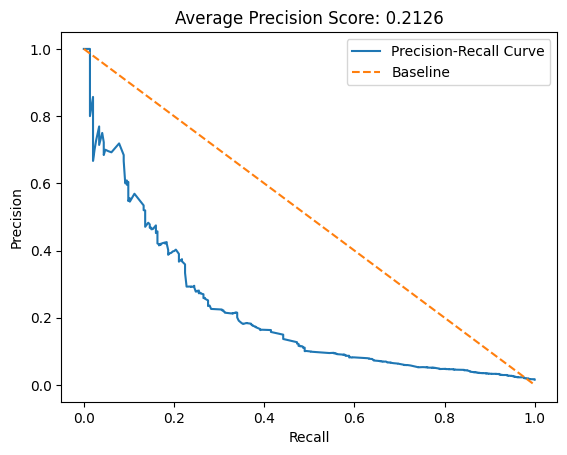

In [29]:
from sklearn.metrics import average_precision_score

def plot_precision_recall_curve(true_labels, preds):
    precision, recall, thresholds = precision_recall_curve(true_labels, preds)
    map = average_precision_score(true_labels, preds)

    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Average Precision Score: {map:.4f}')

    # Plot the baseline diagonal line
    plt.plot([0, 1], [1, 0], linestyle='--', label='Baseline')

    plt.legend()
    plt.show()

plot_precision_recall_curve(y_valid, model.predict(dvalid))

### 2 - Confusion Matrix

Precision: 26.62%
Recall: 26.53%


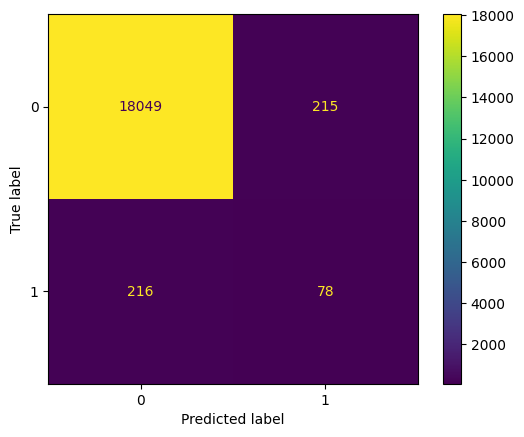

In [36]:
def apply_threshold(y_pred, threshold):
    y_pred_threshold = np.where(y_pred > threshold, 1, 0)
    return y_pred_threshold

threshold = 0.1

y_pred = model.predict(dvalid)
y_pred_threshold = apply_threshold(y_pred, threshold)
y_true = dvalid.get_label()

# Import confusion matrix display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred_threshold)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()

# precision recall values
precision = precision_score(y_true, y_pred_threshold)
recall = recall_score(y_true, y_pred_threshold)

print(f'Precision: {100*precision:.2f}%')
print(f'Recall: {100*recall:.2f}%')

- Pickle the model (serialize)

In [44]:
# Pickle the model
pickle.dump(model, open("model_XGB.pickle", "wb"))

# 4 - Creating the output file

In [45]:
df_test = pd.read_csv("X_test.csv")
X_test = pipe.transform(df_test)

# Import model
model = pickle.load(open("model_XGB.pickle", "rb"))

C:\Users\mabid\AppData\Local\Temp\ipykernel_11692\3721127369.py:1: DtypeWarning: Columns (20,21,22,23,24,68,69,70,71,72,92,93,94,95,96,97,106,107,108,109,110,111,112,113,114,115,116,117,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test = pd.read_csv("X_test.csv")


In [46]:
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)
output = pd.DataFrame({'ID': df_test['ID'], 'fraud_flag' : y_pred})

display(output.head())

,ID,fraud_flag
0,64707,0.000433
1,63919,0.000719
2,15664,0.005805
3,6626,0.013759
4,26766,0.048690


In [ ]:
#output.to_csv('submission.csv', index=False)